# Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import iar
from numpy import linalg as LA
from numba import njit

# Functions

In [47]:
@njit
def IAR_OBI(n, y, times, m0 = 0, P0 = 1):
    sigma = 1
    Estima = np.zeros(n)
    Estima[0] = m0
    X_p = np.zeros(n-1)
    loss = np.zeros(n-1)
    RMSE = np.zeros(n-1)
    acum = 0
    mean_RMSE = 0
    for i in range(1,n):
        HH_1 = y[i-1]
        HH   = y[i]
        phi_1 = Estima[i-1] 
        distancia = times[i] - times[i-1]
        if(distancia > 0):
            V = sigma*(1-phi_1**(2*distancia))
            a1 = ((m0/P0) + (((phi_1**(distancia-1))*(HH_1*HH))/V)) * ((1/P0) + (((phi_1**(2*distancia-2))*(HH_1**2))/V))**(-1)
            if(a1 > 1.0 or a1 < 0.0):
                a1 = phi_1
            b1 = ((1/P0) + (((phi_1**(2*distancia-2))*(HH_1**2))/V))**(-1)
            Estima[i] = a1
        elif (distancia == 0):
            Estima[i] = Estima[i-1]
        m0 = a1
        P0 = b1
        X_t = (a1**distancia)*HH_1
        X_p[i-1] = X_t
        loss[i-1] = (HH -  X_t)**2
        acum = acum + loss[i-1]
        RMSE[i-1] = acum/(i)
        mean_RMSE = mean_RMSE + RMSE[i-1]
    mean_RMSE = mean_RMSE/(n-1)
    return Estima, RMSE, mean_RMSE, X_p, loss

    
@njit
def IAR_OBR(n, y, times, m0, P0):
    sd = np.std(y)
    mk = m0
    Pk = P0
    difer = np.diff(times)
    Param = np.zeros(n)
    Param[0] = m0
    VarPar = np.zeros(n)
    VarPar[0] = P0
    Pred = np.zeros(n)
    MSE = np.zeros(n)
    for k in range(1, n):
        sigma2 = (sd**2)*(1-abs(mk**(difer[k-1]))**2)
        Sk = (y[k-1] * Pk * y[k-1]) + sigma2
        Kk = Pk * y[k-1] * (Sk**(-1))
        mk = mk + Kk * (y[k] - y[k-1] * mk**difer[k-1])
        
        if (mk < 0):
            mk = 0.00001
        if (mk >= 1):
            mk = 0.999999
        Pk = Pk - Kk * Sk * Kk
        if (Pk < 0.005):
            Pk = 0.05
        Param[k] = mk
        VarPar[k] = Pk
        Pred[k] = (mk**difer[k-1])*y[k-1]

    acum = (y[1]-Pred[1])**2
    i = 2
    while(i <= n):
        MSE[i-1] = acum/(i-1)
        acum += (y[i]-Pred[i])**2
        i += 1
    mean_MSE = np.mean(MSE[2:])
    return Param, VarPar, Pred, MSE, mean_MSE

@njit
def update_OGD(y, delta, y0, xhat0, L, learning_rate=0.01):
    K = 0
    nabla = -2*(y-xhat0)*y0*(delta)*(L**(delta-1))
    K = L - learning_rate*nabla
    if K >= 1:
        K = 0.99
    elif K <= 0:
        K = 0.01
    return K

@njit
def IAR_OGD(y, st, L, learning_rate=0.01):
    T = len(y)
    L1 = np.zeros(T)
    L1[0] = L
    X_p = np.zeros(T)
    loss = np.zeros(T)
    MSE = np.zeros(T)
    for t in range(1, T):
        X_t = 0
        X_t = X_t + (L1[t-1]**(st[t]-st[t-1]))*y[t-1]
        X_p[t] = X_t
        loss[t] = (y[t] - X_t)**2
        L = update_OGD(y=y[t], delta=st[t]-st[t-1], y0=y[t-1],
                       xhat0=X_t, L=L, learning_rate=learning_rate)
        L1[t] = L

    acum = loss[1]
    i = 1
    while(i < T):
        MSE[i] = acum/i
        i += 1
        acum += loss[i]
        
    
    mean_MSE = np.mean(MSE[1:])
    return L1, loss, X_p, MSE, mean_MSE

@njit
def update_ONS(y, delta, y0, xhat0, L, A, learning_rate=0.01):
    D = 2
    K = 0
    nabla = -2*(y-xhat0)*y0*(delta)*(L**(delta-1))
    A = A + nabla*nabla
    K = L - (1/learning_rate)*(1/A)*nabla
    if K > 1:
        K = 0.9999999999999999999999999999
    elif K < 0:
        K = 0.01
    return A, K

@njit
def IAR_ONS(y, st, L):
    T = len(y)
    L1 = np.zeros(T)
    L1[0] = L
    Xmax = np.max(np.abs(y))
    D = 2
    G = 2*(Xmax)**2
    Rate = 0.5*np.minimum(1, 4*D*G)
    A = 1/((Rate**2)*(D**2))
    MSE = np.zeros(T)
    x_p = np.zeros(T)
    loss = np.zeros(T)
    for t in range(0, T):
        x_t = 0
        if t > 0:
            x_t = (L1[t-1]**(st[t]-st[t-1]))*y[t-1]
        x_p[t] = x_t
        loss[t] = (y[t]-x_t)**2
        if t > 0:
            A, L = update_ONS(y=y[t], delta=st[t]-st[t-1],
                              y0=y[t-1], xhat0=x_t, L=L, A=A, learning_rate=Rate)
            L1[t] = L
    
    acum = loss[1]
    i = 1
    while(i < T):
        MSE[i] = acum/i
        i += 1
        acum += loss[i]
    
    mean_MSE = np.mean(MSE[1:])
    return L1, loss, x_p, MSE, mean_MSE

@njit
def IARg_OGD(y, st, L0, learning_rate):
    n = len(y)
    L = np.zeros(2)
    L[1] = L0[1]
    L[0] = y[0]
    Mu = np.zeros(n+1)
    Mu[0] = L[0]
    Phi = np.zeros(n+1)
    Phi[0] = L[1]
    x_p = np.zeros(n)
    loss = np.zeros(n)
    RMSE = np.zeros(n)
    nabla = np.zeros(2)
    for t in range(0,n):
        x_t = 0
        if(t > 0):
            x_t = L[0] + ((L[1]**(st[t]-st[t-1]))*y[t-1])
        x_p[t] = x_t
        loss[t] = (y[t]-x_t)**2
        if(t > 0):
            nabla[0] = -2*(y[t]-x_t)
            DT = st[t]-st[t-1]
            nabla[1] = nabla[0]*y[t-1]*DT*(L[1]**(DT-1))
        L[0] = L[0] - learning_rate*nabla[0]
        L[1] = L[1] - learning_rate*nabla[1]
        if(L[1]>1):
            L[1] = 0.999999999999999
        elif(L[1] < 0):
            L[1] = 0.01
        if(L[0]<0):
            L[0] = 0.01
        Mu[t+1] = L[0]
        Phi[t+1] = L[1]
    acum = 0
    for i in range(0,n):
        acum = acum + loss[i]
        RMSE[i] = (acum/(i+1))**(0.5)
    
    return Mu, Phi, loss, RMSE

@njit
def solve(input):
    output = np.zeros(4)
    det = (input[0]*input[3])-(input[1]*input[2])
    output[0] = input[3]/det
    output[1] = -input[1]/det
    output[2] = -input[2]/det
    output[3] = input[0]/det
    return output

@njit
def IARg_ONS(y, st, L0):
    n = len(y)
    L = np.zeros(2)
    L[1] = L0[1]
    L[0] = y[0]
    L1 = np.zeros(n+1)
    L1[0] = L[0]
    L2 = np.zeros(n+1)
    L2[0] = L[1]
    x_p = np.zeros(n)
    loss = np.zeros(n)
    RMSE = np.zeros(n)
    Xmax = np.max(np.abs(y))
    D = 2*(2**0.5)
    G = D*(Xmax*Xmax)
    Rate = 0.5*min(1/(1),4*D*G)
    Epsilon = 1/((Rate*Rate)*(D*D))

    A = np.zeros(4)
    A[0] = Epsilon
    A[3] = Epsilon
    x_t = 0
    nabla = np.zeros(2)
    tempSolve = np.zeros(4)
    DT = 0
    acum = 0
    for t in range(0,n):
        x_t = 0
        if(t>0):
            x_t = L[0] +((L[1]**(st[t]-st[t-1]))*y[t-1])
        x_p[t] = x_t
        loss[t] = (y[t]-x_t)**2
        if(t>0):
            nabla[0] = -2*(y[t]-x_t)
            DT = st[t] -st[t-1]
            nabla[1] = -2*(y[t]-x_t)*y[t-1]*DT*(L[1]**(DT-1))
        A[0] = A[0]+nabla[0]*nabla[0]
        A[1] = A[1]+nabla[1]*nabla[0]
        A[2] = A[2]+nabla[1]*nabla[0]
        A[3] = A[3]+nabla[1]*nabla[1]
        tempSolve = solve(A)
        L[0] = L[0]-(1/Rate)*(tempSolve[0]*nabla[0]+tempSolve[1]*nabla[1])
        L[1] = L[1]-(1/Rate)*(tempSolve[2]*nabla[0]+tempSolve[3]*nabla[1])
        if(L[1]>1):
            L[1] = 0.99999999999999999999
        elif(L[1] < 0):
            L[1] = 0.01
        if(L[0]<0.0):
            L[0] = 0.01
        L1[t+1] = L[0]
        L2[t+1] = L[1]
        acum = acum + loss[t]
        RMSE[t] = (acum/(t+1))**0.5
    return loss, RMSE, L1, L2

In [48]:
def IARPhi_sample(phi, n, st):
    Sigma = np.zeros((n, n))
    for i in range(0, n):
        d = st[i] - st[i:n]
        Sigma[i, i:n] = phi[i]**abs(d)
        Sigma[i:n, i] = Sigma[i, i:n]
    val, vec = LA.eig(Sigma)
    A = np.matmul(np.matmul(vec, np.diag(np.sqrt(val))), np.transpose(vec))
    e = np.random.normal(size = n)
    y = np.dot(A,e)
    return y, st

# Sanity Check Test

In [49]:
# Parametros a probar en simulación
n = 400
phi = 0.5
# Experimentos de MonteCarlo
N = 100
st = np.arange(n)
learning_rate = 0.01
P0 = 0.1

In [50]:
# Inicializar matriz vacía
mat_OBR_P = [[0] * n for i in range(N)]
mat_OBI_P = [[0] * n for i in range(N)]
mat_OGD_P = [[0] * n for i in range(N)]
mat_ONS_P = [[0] * n for i in range(N)]
mat_MLE_P = np.zeros(N)
mat_OBR_MSE = [[0] * n for i in range(N)]
mat_OBI_MSE = [[0] * n for i in range(N)]
mat_OGD_MSE = [[0] * n for i in range(N)]
mat_ONS_MSE = [[0] * n for i in range(N)]

In [51]:
N = 100
for i in range(N):
    m0 = np.random.uniform(0.01,0.99)
    y = iar.IARsample(phi, n, st)
    y = y[0]
    mat_MLE_P[i] = iar.IARloglik(y,st,False)
    mat_OBR_P[i], Var, Pred_OBR, mat_OBR_MSE[i], PromMSE_OBR = IAR_OBR(n, y, st, m0, P0)
    mat_OBI_P[i], Var, Pred_OBR, mat_OBI_MSE[i], PromMSE_OBI = IAR_OBI(n, y, st, m0, P0)
    mat_OGD_P[i], Var, Pred_OGD, mat_OGD_MSE[i], PromMSE_OGD = IAR_OGD(y, st, m0, learning_rate)
    mat_ONS_P[i], Var, Pred_ONS, mat_ONS_MSE[i], PromMSE_ONS = IAR_ONS(y, st, m0)

In [52]:
results_OBR_P = np.zeros(n-1)
results_OBI_P = np.zeros(n-1)
results_OGD_P = np.zeros(n-1)
results_ONS_P = np.zeros(n-1)
sd_OBR = np.zeros(n-1)
sd_OBI = np.zeros(n-1)
sd_OGD = np.zeros(n-1)
sd_ONS = np.zeros(n-1)
aux = 0
val1 = 0; sd1 = 0
val2 = 0; sd2 = 0
val3 = 0; sd3 = 0
val4 = 0; sd4 = 0
for k in range(len(mat_ONS_P[i][0:])-1):
    for i in range(N):
        val2 = val2 + (mat_OGD_P[i][k])
        sd2 = sd2 + (mat_OGD_P[i][k] - np.mean(mat_OGD_P[i]))**2
        val3 = val3 + (mat_ONS_P[i][k])
        sd3 = sd3 + (mat_ONS_P[i][k] - np.mean(mat_ONS_P[i]))**2
    results_OGD_P[aux] = val2/100
    sd_OGD[aux] = np.sqrt(sd2/100)
    results_ONS_P[aux] = val3/100
    sd_ONS[aux] = np.sqrt(sd2/100)
    aux = aux + 1
    val2 = 0
    val3 = 0
    sd2 = 0
    sd3 = 0
aux = 0
for k in range(len(mat_OBR_P[i][0:])-1):
    for i in range(N):
        val1 = val1 + (mat_OBR_P[i][k])
        sd1 = sd1 + (mat_OBR_P[i][k] - np.mean(mat_OBR_P[i]))**2
        val4 = val4 + (mat_OBI_P[i][k])
        sd4 = sd4 + (mat_OBI_P[i][k] - np.mean(mat_OBI_P[i]))**2
    results_OBR_P[aux] = val1/100
    sd_OBR[aux] = np.sqrt(sd1/100)
    results_OBI_P[aux] = val4/100
    sd_OBI[aux] = np.sqrt(sd4/100)
    aux = aux + 1
    val1 = 0
    sd1 = 0
    val4 = 0
    sd4 = 0
IC_low_OBR = results_OBR_P-( (sd_OBR/10) * 1.96)
IC_upp_OBR = results_OBR_P+( (sd_OBR/10) * 1.96)
IC_low_OBI = results_OBI_P-( (sd_OBI/10) * 1.96)
IC_upp_OBI = results_OBI_P+( (sd_OBI/10) * 1.96)
IC_low_OGD = results_OGD_P-( (sd_OGD/10) * 1.96)
IC_upp_OGD = results_OGD_P+( (sd_OGD/10) * 1.96)
IC_low_ONS = results_ONS_P-( (sd_ONS/10) * 1.96)
IC_upp_ONS = results_ONS_P+( (sd_ONS/10) * 1.96)

res_MLE_P = np.mean(mat_MLE_P)

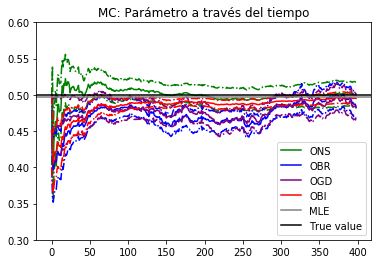

In [56]:
plt.plot(np.arange(len(results_ONS_P)), results_ONS_P, "-", label = "ONS",color="green")
plt.plot(np.arange(len(results_ONS_P)), IC_low_ONS, "-.", color="green")
plt.plot(np.arange(len(results_ONS_P)), IC_upp_ONS, "-.", color="green")
plt.plot(np.arange(len(results_OBR_P)), results_OBR_P, "-", label = "OBR",color="blue")
plt.plot(np.arange(len(results_OBR_P)), IC_low_OBR, "-.", color="blue")
plt.plot(np.arange(len(results_OBR_P)), IC_upp_OBR, "-.", color="blue")
plt.plot(np.arange(len(results_OGD_P)), results_OGD_P, "-", label = "OGD",color="purple")
plt.plot(np.arange(len(results_OGD_P)), IC_low_OGD, "-.", color="purple")
plt.plot(np.arange(len(results_OGD_P)), IC_upp_OGD, "-.", color="purple")
plt.plot(np.arange(len(results_OBI_P)), results_OBI_P, "-", label = "OBI",color="red")
plt.plot(np.arange(len(results_OBI_P)), IC_low_OBI, "-.", color="red")
plt.plot(np.arange(len(results_OBI_P)), IC_upp_OBI, "-.", color="red")
plt.axhline(res_MLE_P, label = "MLE", color = "grey")
plt.axhline(phi, label = "True value", color = "black")
plt.ylim([0.3, 0.6])
plt.legend()
plt.title("MC: Change in parameter estimation over time")
plt.show()

# Abrupt Change Test

In [57]:
# Parametros a probar en simulación
n = 400
phi1 = 0.4
phi2 = 0.8
# Experimentos de MonteCarlo
N = 100
st = np.arange(n)
learning_rate = 0.01
P0 = 0.1

In [58]:
# Inicializar matriz vacía
mat_OBR_P = [[0] * n for i in range(N)]
mat_OBI_P = [[0] * n for i in range(N)]
mat_OGD_P = [[0] * n for i in range(N)]
mat_ONS_P = [[0] * n for i in range(N)]
mat_MLE_P = np.zeros(N)
mat_OBR_MSE = [[0] * n for i in range(N)]
mat_OBI_MSE = [[0] * n for i in range(N)]
mat_OGD_MSE = [[0] * n for i in range(N)]
mat_ONS_MSE = [[0] * n for i in range(N)]

In [59]:
# N = 100
for i in range(N):
    m0 = np.random.uniform(0.01,0.99)
    y1 = iar.IARsample(phi1, 200, st[0:200])
    y2 = iar.IARsample(phi2, 200, st[200:400])
    y = np.concatenate((y1[0], y2[0]), axis = 0)
    mat_MLE_P[i] = iar.IARloglik(y,st,False)
    mat_OBR_P[i], Var, Pred_OBR, mat_OBR_MSE[i], PromMSE_OBR = IAR_OBR(n, y, st, m0, P0)
    mat_OBI_P[i], Var, Pred_OBR, mat_OBI_MSE[i], PromMSE_OBI = IAR_OBI(n, y, st, m0, P0)
    mat_OGD_P[i], Var, Pred_OGD, mat_OGD_MSE[i], PromMSE_OGD = IAR_OGD(y, st, m0, learning_rate)
    mat_ONS_P[i], Var, Pred_ONS, mat_ONS_MSE[i], PromMSE_ONS = IAR_ONS(y, st, m0)

In [60]:
results_OBR_P = np.zeros(n-1)
results_OBI_P = np.zeros(n-1)
results_OGD_P = np.zeros(n-1)
results_ONS_P = np.zeros(n-1)
sd_OBR = np.zeros(n-1)
sd_OBI = np.zeros(n-1)
sd_OGD = np.zeros(n-1)
sd_ONS = np.zeros(n-1)
aux = 0
val1 = 0; sd1 = 0
val2 = 0; sd2 = 0
val3 = 0; sd3 = 0
val4 = 0; sd4 = 0
for k in range(len(mat_ONS_P[i][0:])-1):
    for i in range(N):
        val2 = val2 + (mat_OGD_P[i][k])
        sd2 = sd2 + (mat_OGD_P[i][k] - np.mean(mat_OGD_P[i]))**2
        val3 = val3 + (mat_ONS_P[i][k])
        sd3 = sd3 + (mat_ONS_P[i][k] - np.mean(mat_ONS_P[i]))**2
    results_OGD_P[aux] = val2/100
    sd_OGD[aux] = np.sqrt(sd2/100)
    results_ONS_P[aux] = val3/100
    sd_ONS[aux] = np.sqrt(sd2/100)
    aux = aux + 1
    val2 = 0
    val3 = 0
    sd2 = 0
    sd3 = 0
aux = 0
for k in range(len(mat_OBR_P[i][0:])-1):
    for i in range(N):
        val1 = val1 + (mat_OBR_P[i][k])
        sd1 = sd1 + (mat_OBR_P[i][k] - np.mean(mat_OBR_P[i]))**2
        val4 = val4 + (mat_OBI_P[i][k])
        sd4 = sd4 + (mat_OBI_P[i][k] - np.mean(mat_OBI_P[i]))**2
    results_OBR_P[aux] = val1/100
    sd_OBR[aux] = np.sqrt(sd1/100)
    results_OBI_P[aux] = val4/100
    sd_OBI[aux] = np.sqrt(sd4/100)
    aux = aux + 1
    val1 = 0
    sd1 = 0
    val4 = 0
    sd4 = 0
IC_low_OBR = results_OBR_P-( (sd_OBR/10) * 1.96)
IC_upp_OBR = results_OBR_P+( (sd_OBR/10) * 1.96)
IC_low_OBI = results_OBI_P-( (sd_OBI/10) * 1.96)
IC_upp_OBI = results_OBI_P+( (sd_OBI/10) * 1.96)
IC_low_OGD = results_OGD_P-( (sd_OGD/10) * 1.96)
IC_upp_OGD = results_OGD_P+( (sd_OGD/10) * 1.96)
IC_low_ONS = results_ONS_P-( (sd_ONS/10) * 1.96)
IC_upp_ONS = results_ONS_P+( (sd_ONS/10) * 1.96)

res_MLE_P = np.mean(mat_MLE_P)

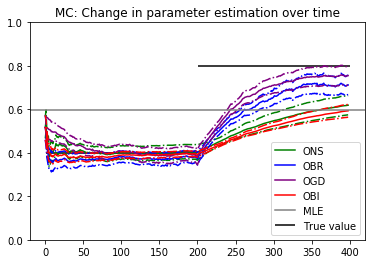

In [62]:
plt.plot(np.arange(len(results_ONS_P)), results_ONS_P, "-", label = "ONS",color="green")
plt.plot(np.arange(len(results_ONS_P)), IC_low_ONS, "-.", color="green")
plt.plot(np.arange(len(results_ONS_P)), IC_upp_ONS, "-.", color="green")
plt.plot(np.arange(len(results_OBR_P)), results_OBR_P, "-", label = "OBR",color="blue")
plt.plot(np.arange(len(results_OBR_P)), IC_low_OBR, "-.", color="blue")
plt.plot(np.arange(len(results_OBR_P)), IC_upp_OBR, "-.", color="blue")
plt.plot(np.arange(len(results_OGD_P)), results_OGD_P, "-", label = "OGD",color="purple")
plt.plot(np.arange(len(results_OGD_P)), IC_low_OGD, "-.", color="purple")
plt.plot(np.arange(len(results_OGD_P)), IC_upp_OGD, "-.", color="purple")
plt.plot(np.arange(len(results_OBI_P)), results_OBI_P, "-", label = "OBI",color="red")
plt.plot(np.arange(len(results_OBI_P)), IC_low_OBI, "-.", color="red")
plt.plot(np.arange(len(results_OBI_P)), IC_upp_OBI, "-.", color="red")
plt.axhline(res_MLE_P, label = "MLE", color = "grey")
plt.hlines(y=phi1, xmin=1, xmax=200, label = "True value", color = "black",zorder=1)
plt.hlines(y=phi2, xmin=201, xmax=400, color = "black",zorder=1)
plt.ylim([0, 1])
plt.legend()
plt.title("MC: Change in parameter estimation over time")
plt.show()

# Constant Change Test

In [63]:
# Parametros a probar en simulación
n = 400
phi1 = 0.8
phi2 = 0.4
# Experimentos de MonteCarlo
N = 100
st = np.arange(n)
learning_rate = 0.01
P0 = 0.1

In [64]:
# Inicializar matriz vacía
mat_OBR_P = [[0] * n for i in range(N)]
mat_OBI_P = [[0] * n for i in range(N)]
mat_OGD_P = [[0] * n for i in range(N)]
mat_ONS_P = [[0] * n for i in range(N)]
mat_MLE_P = np.zeros(N)
mat_OBR_MSE = [[0] * n for i in range(N)]
mat_OBI_MSE = [[0] * n for i in range(N)]
mat_OGD_MSE = [[0] * n for i in range(N)]
mat_ONS_MSE = [[0] * n for i in range(N)]

In [65]:
cambio = abs(phi1-phi2)/(n-1)
CPhi = np.zeros(n)
for i in range(0, n):
    if phi1 < phi2: 
        CPhi[i] = phi2 - cambio * (i)
    else: 
        CPhi[i] = phi2 + cambio * (i)

In [66]:
# N = 100
for i in range(N):
    m0 = np.random.uniform(0.01, 0.99)
    y, st = IARPhi_sample(CPhi, n, st)
    mat_MLE_P[i] = iar.IARloglik(y, st, False)
    mat_OBR_P[i], Var, Pred_OBR, mat_OBR_MSE[i], PromMSE_OBR = IAR_OBR(
        n, y, st, m0, P0)
    mat_OBI_P[i], Var, Pred_OBI, mat_OBI_MSE[i], PromMSE_OBI = IAR_OBI(
        n, y, st, m0, P0)
    mat_OGD_P[i], Var, Pred_OGD, mat_OGD_MSE[i], PromMSE_OGD = IAR_OGD(
        y, st, m0, learning_rate)
    mat_ONS_P[i], Var, Pred_ONS, mat_ONS_MSE[i], PromMSE_ONS = IAR_ONS(
        y, st, m0)

In [67]:
results_OBR_P = np.zeros(n-1)
results_OBI_P = np.zeros(n-1)
results_OGD_P = np.zeros(n-1)
results_ONS_P = np.zeros(n-1)
sd_OBR = np.zeros(n-1)
sd_OBI = np.zeros(n-1)
sd_OGD = np.zeros(n-1)
sd_ONS = np.zeros(n-1)
aux = 0
val1 = 0; sd1 = 0
val2 = 0; sd2 = 0
val3 = 0; sd3 = 0
val4 = 0; sd4 = 0
for k in range(len(mat_ONS_P[i][0:])-1):
    for i in range(N):
        val2 = val2 + (mat_OGD_P[i][k])
        sd2 = sd2 + (mat_OGD_P[i][k] - np.mean(mat_OGD_P[i]))**2
        val3 = val3 + (mat_ONS_P[i][k])
        sd3 = sd3 + (mat_ONS_P[i][k] - np.mean(mat_ONS_P[i]))**2
    results_OGD_P[aux] = val2/100
    sd_OGD[aux] = np.sqrt(sd2/100)
    results_ONS_P[aux] = val3/100
    sd_ONS[aux] = np.sqrt(sd2/100)
    aux = aux + 1
    val2 = 0
    val3 = 0
    sd2 = 0
    sd3 = 0
aux = 0
for k in range(len(mat_OBR_P[i][0:])-1):
    for i in range(N):
        val1 = val1 + (mat_OBR_P[i][k])
        sd1 = sd1 + (mat_OBR_P[i][k] - np.mean(mat_OBR_P[i]))**2
        val4 = val4 + (mat_OBI_P[i][k])
        sd4 = sd4 + (mat_OBI_P[i][k] - np.mean(mat_OBI_P[i]))**2
    results_OBR_P[aux] = val1/100
    sd_OBR[aux] = np.sqrt(sd1/100)
    results_OBI_P[aux] = val4/100
    sd_OBI[aux] = np.sqrt(sd4/100)
    aux = aux + 1
    val1 = 0
    sd1 = 0
    val4 = 0
    sd4 = 0
IC_low_OBR = results_OBR_P-( (sd_OBR/10) * 1.96)
IC_upp_OBR = results_OBR_P+( (sd_OBR/10) * 1.96)
IC_low_OBI = results_OBI_P-( (sd_OBI/10) * 1.96)
IC_upp_OBI = results_OBI_P+( (sd_OBI/10) * 1.96)
IC_low_OGD = results_OGD_P-( (sd_OGD/10) * 1.96)
IC_upp_OGD = results_OGD_P+( (sd_OGD/10) * 1.96)
IC_low_ONS = results_ONS_P-( (sd_ONS/10) * 1.96)
IC_upp_ONS = results_ONS_P+( (sd_ONS/10) * 1.96)

res_MLE_P = np.mean(mat_MLE_P)

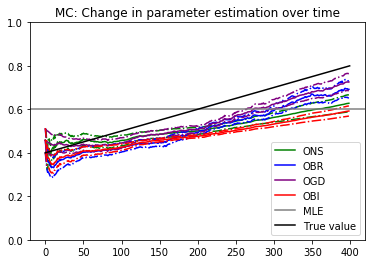

In [68]:
plt.plot(np.arange(len(results_ONS_P)), results_ONS_P, "-", label = "ONS",color="green")
plt.plot(np.arange(len(results_ONS_P)), IC_low_ONS, "-.", color="green")
plt.plot(np.arange(len(results_ONS_P)), IC_upp_ONS, "-.", color="green")
plt.plot(np.arange(len(results_OBR_P)), results_OBR_P, "-", label = "OBR",color="blue")
plt.plot(np.arange(len(results_OBR_P)), IC_low_OBR, "-.", color="blue")
plt.plot(np.arange(len(results_OBR_P)), IC_upp_OBR, "-.", color="blue")
plt.plot(np.arange(len(results_OGD_P)), results_OGD_P, "-", label = "OGD",color="purple")
plt.plot(np.arange(len(results_OGD_P)), IC_low_OGD, "-.", color="purple")
plt.plot(np.arange(len(results_OGD_P)), IC_upp_OGD, "-.", color="purple")
plt.plot(np.arange(len(results_OBI_P)), results_OBI_P, "-", label = "OBI",color="red")
plt.plot(np.arange(len(results_OBI_P)), IC_low_OBI, "-.", color="red")
plt.plot(np.arange(len(results_OBI_P)), IC_upp_OBI, "-.", color="red")
plt.axhline(res_MLE_P, label = "MLE", color = "grey")
plt.plot(np.arange(len(CPhi)), CPhi, "-", label = "True value",color="black")
plt.ylim([0, 1])
plt.legend()
plt.title("MC: Change in parameter estimation over time")
plt.show()